In [1]:
import os
import glob
import sys
import subprocess
import xarray as xr
import numpy as np
from time import perf_counter

THIS_DIR = os.path.abspath('')
sys.path.append(os.path.join(THIS_DIR, os.pardir, os.pardir, os.pardir))

from src.quincy.IO.NamelistReader import NamelistReader
from src.quincy.IO.LctlibReader import LctlibReader
from src.quincy.base import Namelist
from src.sens.base import Quincy_Setup
from src.sens.base import Quincy_Single_Run
from src.quincy.base.EnvironmentalInputTypes import *
from src.quincy.base.NamelistTypes import *
from src.quincy.base.PFTTypes import PftQuincy
from src.quincy.base.EnvironmentalInput import EnvironmentalInputSite
from src.quincy.base.user_git_information import UserGitInformation
from src.quincy.run_scripts.default import ApplyDefaultTestbed

if 'QUINCY' in os.environ:        
    QUINCY_ROOT_PATH = os.environ.get("QUINCY")
else:
    print("Environmental variable QUINCY is not defined")
    print("Please set QUINCY to the directory of your quincy root path")
    exit(99)
    
OUTPUT_DIR = 'output/quincy_simphony_test_bed'

In [45]:
# Classic sensitivity analysis where we are apply differnt Namelist or Lctlib files to ONE climate file
# The basic forcing path
# We need a base namelist and lctlib which we then modify accordingly
namelist_root_path = os.path.join(QUINCY_ROOT_PATH,'contrib', 'namelist' ,'namelist.slm')
lctlib_root_path = os.path.join(QUINCY_ROOT_PATH,'data', 'lctlib_quincy_nlct14.def')
# Path where to save the setup
setup_root_path = os.path.join(THIS_DIR, OUTPUT_DIR)

# Parse base namelist path
nlm_reader = NamelistReader(namelist_root_path)
namelist_base = nlm_reader.parse()


# Fluxnet3 forcing
forcing = ForcingDataset.FLUXNET3
# Fluxnet3 sites
site = "DE-Hai"
# Use static forcing
forcing_mode = ForcingMode.STATIC


user_git_info = UserGitInformation(QUINCY_ROOT_PATH, 
                                           setup_root_path, 
                                           site)  

env_input = EnvironmentalInputSite(forcing_mode=forcing_mode, 
                                forcing_dataset=forcing)

# Parse paths of the forcing
namelist_base, forcing_file = env_input.parse_single_site(namelist=namelist_base, site=site)

# Apply the testbed configuration 
ApplyDefaultTestbed(namelist=namelist_base)        

# Apply the standard selected output variables    
namelist_base.base_ctl.file_sel_output_variables.value = os.path.join(QUINCY_ROOT_PATH,
                                                                        'data', 
                                                                        'basic_output_variables.txt')

# Set Plant hydraulics on
namelist_base.assimilation_ctl.gs_beta_type.value = GsBetaType.PLANT
namelist_base.phyd_ctl.use_plant_hydraulics.value = True


pft = namelist_base.vegetation_ctl.plant_functional_type_id

# Parse base lctlibe path
lctlib_reader = LctlibReader(lctlib_root_path)
lctlib_base = lctlib_reader.parse()


pft_id = namelist_base.vegetation_ctl.plant_functional_type_id.value

pft = PftQuincy(pft_id)
lctlib_base[pft].k_xylem_sat = 5.0
lctlib_base[pft].psi50_xylem = -3.5
lctlib_base[pft].kappa_stem = 100
lctlib_base[pft].kappa_leaf = 0.005


# We create a single quincy setup
quincy_single_run_config = Quincy_Single_Run(setup_root_path)

#Create one QUINCY setup
quincy_setup = Quincy_Setup(folder = setup_root_path,
                            namelist = namelist_base, 
                            lctlib = lctlib_base, forcing_path=forcing_file,
                            user_git_info= user_git_info)
# Export setup
quincy_single_run_config.set_setup(quincy_setup)
quincy_single_run_config.generate_files()



In [46]:
pft

<PftQuincy.BDS: 4>

In [47]:
lctlib_base[pft].k_xylem_sat

5.0

In [48]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Quincy run scripts
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

t1 = perf_counter()

quincy_binary_path = os.path.join(QUINCY_ROOT_PATH, "x86_64-gfortran", "bin", "land.x")

p = subprocess.Popen(quincy_binary_path,
                        cwd=setup_root_path)

stdout, stderr = p.communicate()
returncode = p.returncode

t2 = perf_counter()
print(f"Elapsed: {t2-t1} seconds.")

  
 #########################
  Start QUINCY model Init 
 mo_spq_init:calc_soil_texture_saxton_compatible Modified the soil texture sand input for saxton calculation:   0.16000000000000000       0.16000000000000000       0.16000000000000000       0.16000000000000000       0.16000000000000000     
 mo_spq_init:calc_soil_texture_saxton_compatible Modified the soil texture clay input for saxton calculation:   -7.4239999999999973E-002  -7.4239999999999973E-002  -7.4239999999999973E-002  -7.4239999999999973E-002  -7.4239999999999973E-002
 mo_spq_init:calc_soil_texture_saxton_compatible Modified the soil texture silt input for saxton calculation:   -8.5760000000000003E-002  -8.5760000000000003E-002  -8.5760000000000003E-002  -8.5760000000000003E-002  -8.5760000000000003E-002
 Found selected output variable file: /Net/Groups/BSI/work_scratch/ppapastefanou/src/quincy/data/basic_output_variables.txt containing 44 output variables.
 If you want to ensure to have the correct years associated with

In [ ]:
from src.postprocessing.qnc_defintions import Output_format
from src.postprocessing.qnc_output_parser import QNC_output_parser
from src.postprocessing.qnc_ncdf_reader import QNC_ncdf_reader

In [49]:
parser = QNC_output_parser(OUTPUT_DIR)
parser.Read()
output = parser.Available_outputs['static']

In [50]:
nc_output = QNC_ncdf_reader(OUTPUT_DIR,
                                        output.Categories,
                                        output.Identifier,
                                        output.Time_resolution
                                        )

nc_output.Parse_env_and_variables()
nc_output.Read_all_1D()
nc_output.Close()

     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (1.7 sec.)
     Reading variable names and units... Done! (1.7 sec.)
     Reading all 1D variables... Done! (0.3 sec.)


In [51]:
nc_output.Dataset_Names_1D

{'VEG': ['vegpool_leaf_C',
  'vegpool_fine_root_C',
  'vegpool_coarse_root_C',
  'vegpool_sap_wood_C',
  'vegpool_heart_wood_C',
  'vegpool_labile_C',
  'vegpool_reserve_C',
  'vegpool_fruit_C',
  'total_veg_c',
  'height',
  'diameter',
  'beta_sinklim',
  'LAI',
  'growth_resp_avg',
  'maint_resp_avg',
  'npp_avg'],
 'Q_ASSIMI': ['gpp_avg', 'gc_avg', 'ga_avg', 'beta_gs', 'beta_ps'],
 'RAD': ['albedo_avg', 'appfd_avg'],
 'SB': ['sol_litter_C', 'het_respiration_avg'],
 'SPQ': ['water_content_soil',
  'evaporation_avg',
  'interception_avg',
  'transpiration_avg',
  'srf_runoff_avg',
  'drainage_avg',
  'qh_avg',
  'qle_avg',
  'qg_avg'],
 'PHYD': ['psi_leaf_avg', 'psi_stem_avg', 'stem_flow_avg', 'G_avg'],
 'Q_PHENO': ['growing_season']}

In [52]:
nc_output.Datasets_1D['PHYD']

index                date         time  psi_leaf_avg  psi_stem_avg  \
0            0 1993-01-01 00:00:00       1800.0     -0.020000     -0.010000   
1            1 1993-01-01 00:30:00       3600.0     -0.020000     -0.010000   
2            2 1993-01-01 01:00:00       5400.0     -0.020000     -0.010000   
3            3 1993-01-01 01:30:00       7200.0     -0.020000     -0.010000   
4            4 1993-01-01 02:00:00       9000.0     -0.020000     -0.010000   
...        ...                 ...          ...           ...           ...   
350395  350395 2012-12-31 21:30:00  630712800.0     -0.104054     -0.032996   
350396  350396 2012-12-31 22:00:00  630714600.0     -0.104054     -0.032996   
350397  350397 2012-12-31 22:30:00  630716400.0     -0.104054     -0.032996   
350398  350398 2012-12-31 23:00:00  630718200.0     -0.104054     -0.032996   
350399  350399 2012-12-31 23:30:00  630720000.0     -0.104054     -0.032996   

        stem_flow_avg  G_avg  
0                 0.0    0.0  
1                 0.0    0.0  
2                 0.0    0.0  
3                 0.0    0.0  
4                 0.0    0.0  
...               ...    ...  
350395            0.0    0.0  
350396            0.0    0.0  
350397            0.0    0.0  
350398            0.0    0.0  
350399            0.0    0.0  

[350400 rows x 7 columns]

In [53]:
import matplotlib.pyplot as plt
import datetime

(12996.0, 13027.0)

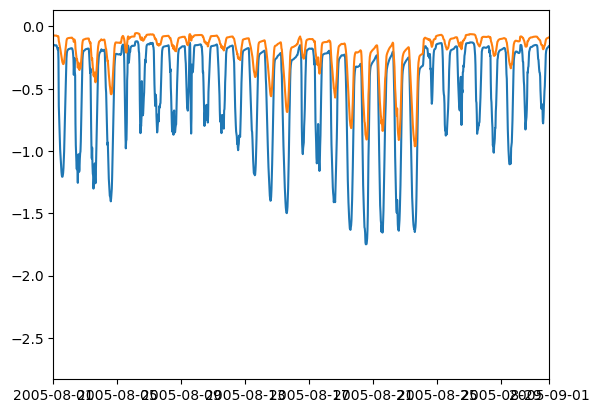

In [63]:
plt.plot(nc_output.Datasets_1D['PHYD']['date'], nc_output.Datasets_1D['PHYD']['psi_leaf_avg'] )
plt.plot(nc_output.Datasets_1D['PHYD']['date'], nc_output.Datasets_1D['PHYD']['psi_stem_avg'] )
plt.xlim((datetime.datetime(2005,8,1),datetime.datetime(2005,9,1)))

(12996.0, 13027.0)

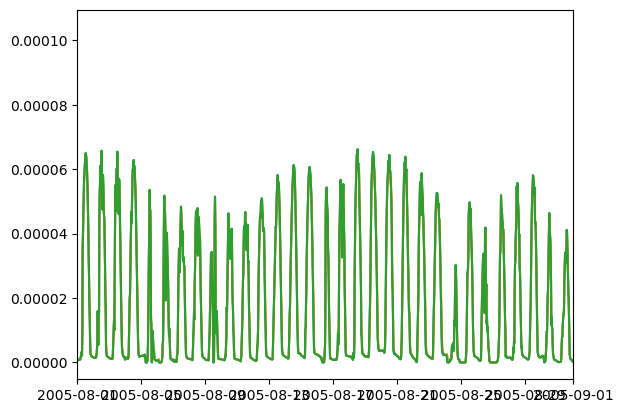

In [64]:
plt.plot(nc_output.Datasets_1D['PHYD']['date'], nc_output.Datasets_1D['PHYD']['stem_flow_avg'] )
plt.plot(nc_output.Datasets_1D['PHYD']['date'], nc_output.Datasets_1D['PHYD']['G_avg'] )
plt.plot(nc_output.Datasets_1D['PHYD']['date'], nc_output.Datasets_1D['SPQ']['transpiration_avg'])
# plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['psi_stem_avg'] )
plt.xlim((datetime.datetime(2005,8,1),datetime.datetime(2005,9,1)))

In [ ]:
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['stem_flow_avg'] )
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['G_avg'] )
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['SPQ']['transpiration_avg'] * 1000/18.0 )
plt.xlim((datetime.datetime(2005,5,5),datetime.datetime(2005,9,1)))

AttributeError: 'QNC_ncdf_reader' object has no attribute 'times_np_64'

(12913.0, 12935.0)

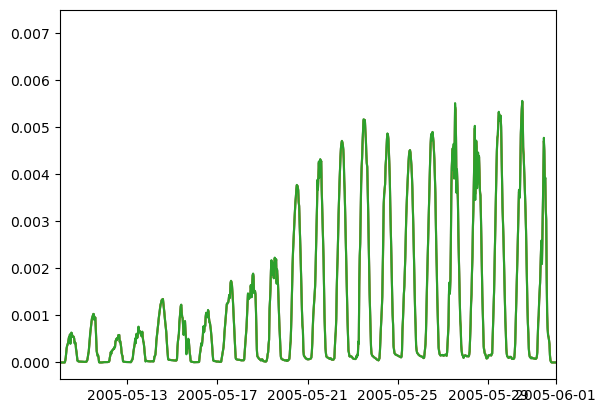

In [ ]:
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['stem_flow_avg'] )
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['G_avg'] )
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['SPQ']['transpiration_avg'] * 1000/18.0 )
plt.xlim((datetime.datetime(2005,5,10),datetime.datetime(2005,6,1)))

(12913.0, 12935.0)

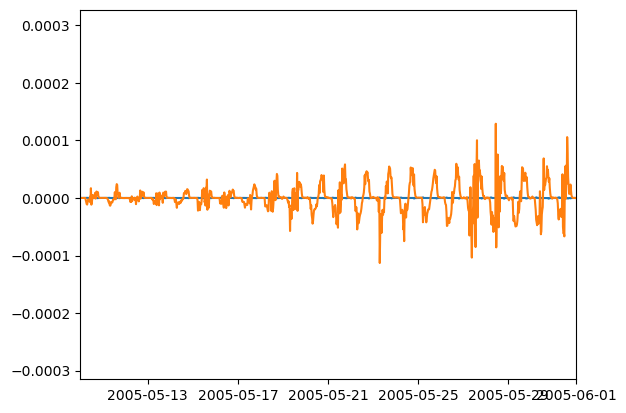

In [ ]:
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['stem_flow_avg']- nc_output.Datasets_1D['PHYD']['G_avg'] )
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['stem_flow_avg']- nc_output.Datasets_1D['SPQ']['transpiration_avg'] * 1000/18.0 )
plt.xlim((datetime.datetime(2005,5,10),datetime.datetime(2005,6,1)))